# Депрессивные студенты. 
## Предсказание наличие депрессим у студентов из Индии

В этом проекте мы будем строить модели классификации студентов по целевой переменной depression. Мы пройдем через следующие этапы:
1. EDA (Exploratory Data Analysis)
2. Preprocessing & Feature Engineering
3. Моделирование
4. Подбор гиперпараметров

In [68]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from  matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from catboost import CatBoostClassifier, CatBoost, Pool

from category_encoders import OrdinalEncoder, OneHotEncoder

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

np.random.seed(10)
sns.set_theme("notebook")

In [28]:
# Загрузка данных
raw_data = pd.read_csv('student_depression_dataset.csv')
print(f"Размер датасета: {raw_data.shape}")
raw_data.head()

Размер датасета: (27901, 18)


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


## Часть 1: EDA (Exploratory Data Analysis)

In [29]:
# Базовая информация о датасете
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27901 entries, 0 to 27900
Data columns (total 18 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     27901 non-null  int64  
 1   Gender                                 27901 non-null  object 
 2   Age                                    27901 non-null  float64
 3   City                                   27901 non-null  object 
 4   Profession                             27901 non-null  object 
 5   Academic Pressure                      27901 non-null  float64
 6   Work Pressure                          27901 non-null  float64
 7   CGPA                                   27901 non-null  float64
 8   Study Satisfaction                     27901 non-null  float64
 9   Job Satisfaction                       27901 non-null  float64
 10  Sleep Duration                         27901 non-null  object 
 11  Di

In [30]:
# Количество числовых и категориальных данных
raw_data.dtypes.value_counts()

object     9
float64    7
int64      2
Name: count, dtype: int64

In [31]:
# Статистическое описание числовых признаков
raw_data.describe()

,id,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,7.156984,0.585499
std,40641.175216,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,3.707642,0.492645
min,2.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000
50%,70684.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,8.000000,1.000000
75%,105818.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,10.000000,1.000000
max,140699.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,12.000000,1.000000


In [32]:
# Проверка пропущенных значений
missing_values = raw_data.isnull().sum()
missing_percentage = (missing_values / len(raw_data)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
missing_df[missing_df['Missing Values'] > 0]

,Missing Values,Percentage


<Axes: xlabel='Depression', ylabel='Percent'>

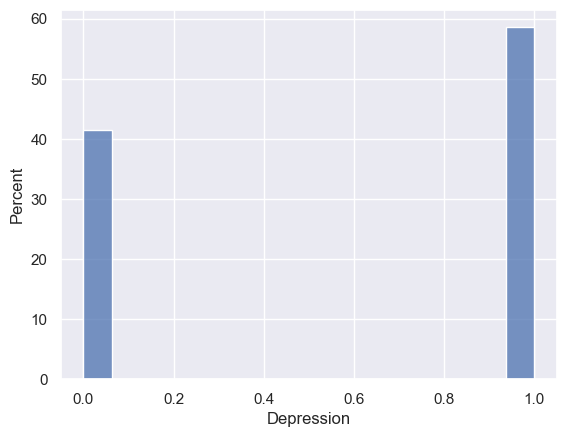

In [33]:
# Распределение целевой переменной
sns.histplot(raw_data['Depression'],stat='percent')

In [34]:
# Поиск всех категориальных признаков
categorical_cols = raw_data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col.title())
    print(raw_data[col].unique())
    print(len(raw_data[col].unique()))
    print("_______________________________")

Gender
['Male' 'Female']
2
_______________________________
City
['Visakhapatnam' 'Bangalore' 'Srinagar' 'Varanasi' 'Jaipur' 'Pune' 'Thane'
 'Chennai' 'Nagpur' 'Nashik' 'Vadodara' 'Kalyan' 'Rajkot' 'Ahmedabad'
 'Kolkata' 'Mumbai' 'Lucknow' 'Indore' 'Surat' 'Ludhiana' 'Bhopal'
 'Meerut' 'Agra' 'Ghaziabad' 'Hyderabad' 'Vasai-Virar' 'Kanpur' 'Patna'
 'Faridabad' 'Delhi' 'Saanvi' 'M.Tech' 'Bhavna' "'Less Delhi'" 'City'
 '3.0' "'Less than 5 Kalyan'" 'Mira' 'Harsha' 'Vaanya' 'Gaurav' 'Harsh'
 'Reyansh' 'Kibara' 'Rashi' 'ME' 'M.Com' 'Nalyan' 'Mihir' 'Nalini'
 'Nandini' 'Khaziabad']
52
_______________________________
Profession
['Student' "'Civil Engineer'" 'Architect' "'UX/UI Designer'"
 "'Digital Marketer'" "'Content Writer'" "'Educational Consultant'"
 'Teacher' 'Manager' 'Chef' 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']
14
_______________________________
Sleep Duration
["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
5
_______________________________
D

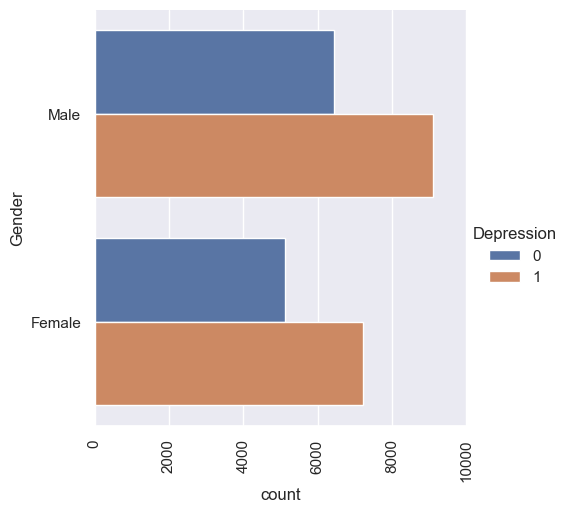

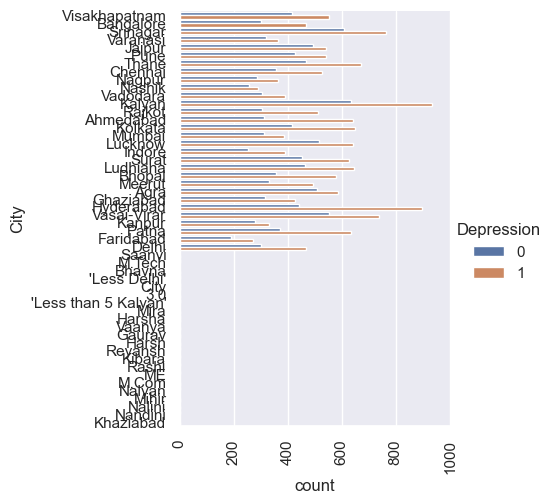

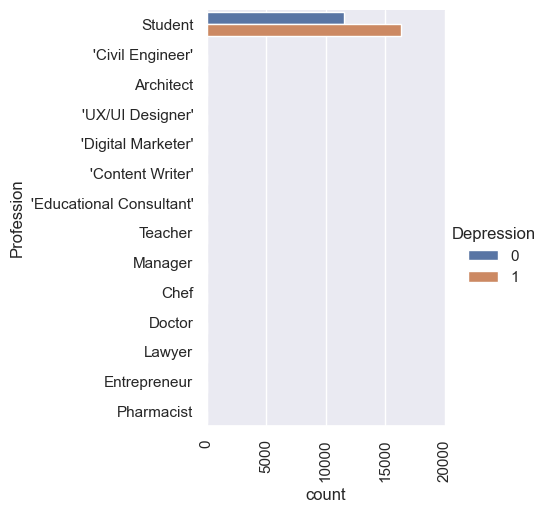

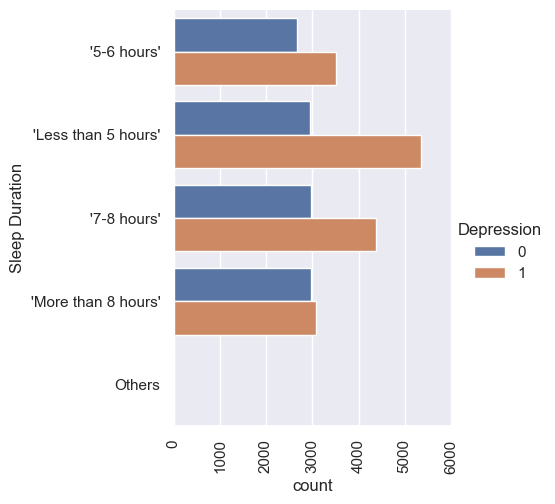

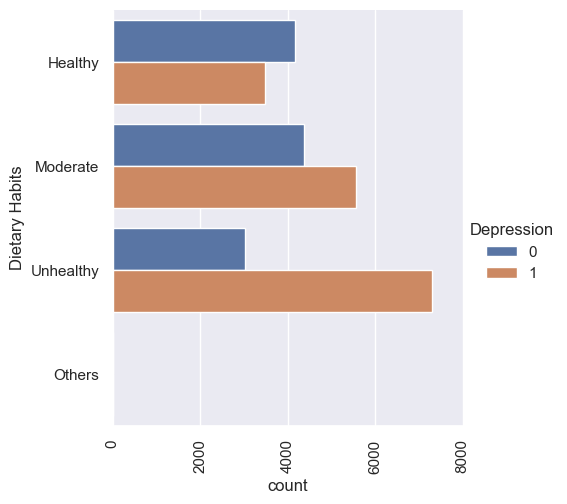

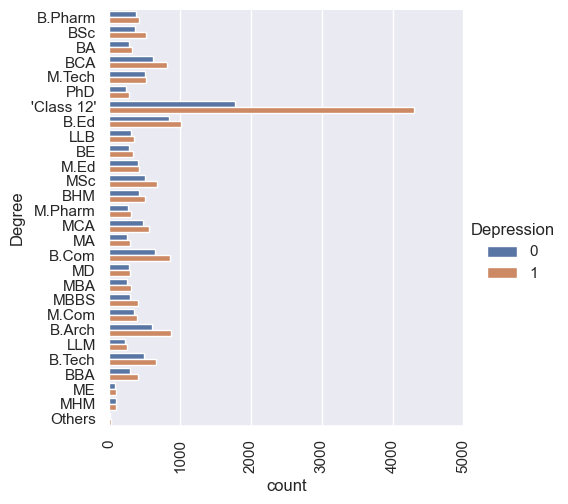

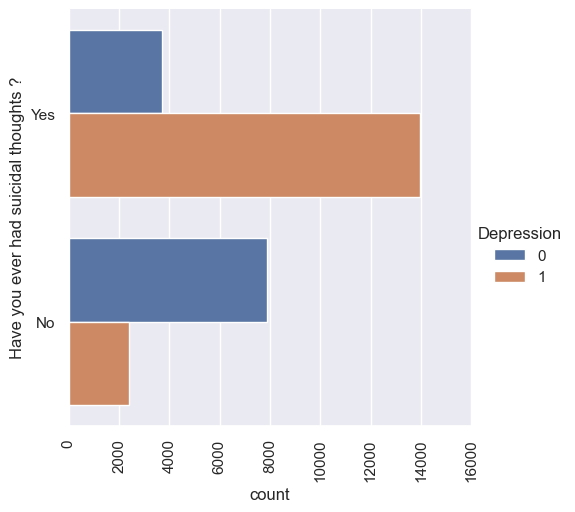

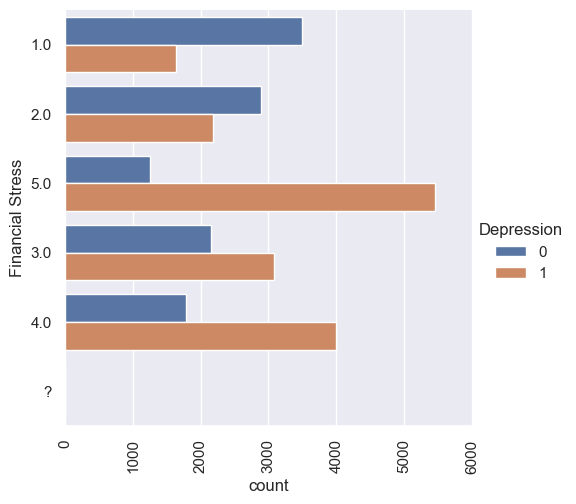

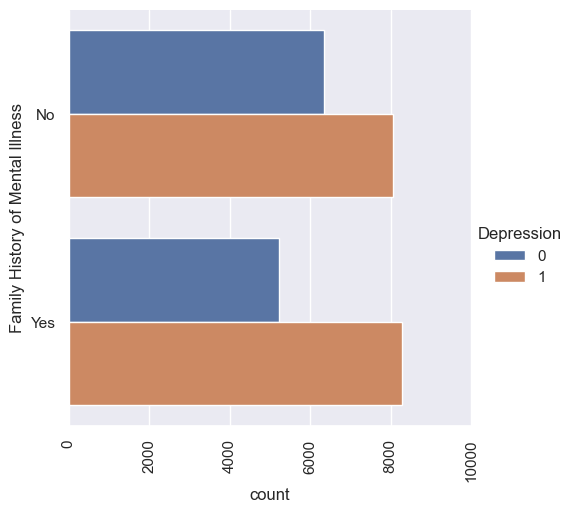

In [35]:

for i in categorical_cols:
    g = sns.catplot(data=raw_data, hue='Depression',y=i, kind='count')
    g.set_xticklabels(rotation=90)

    

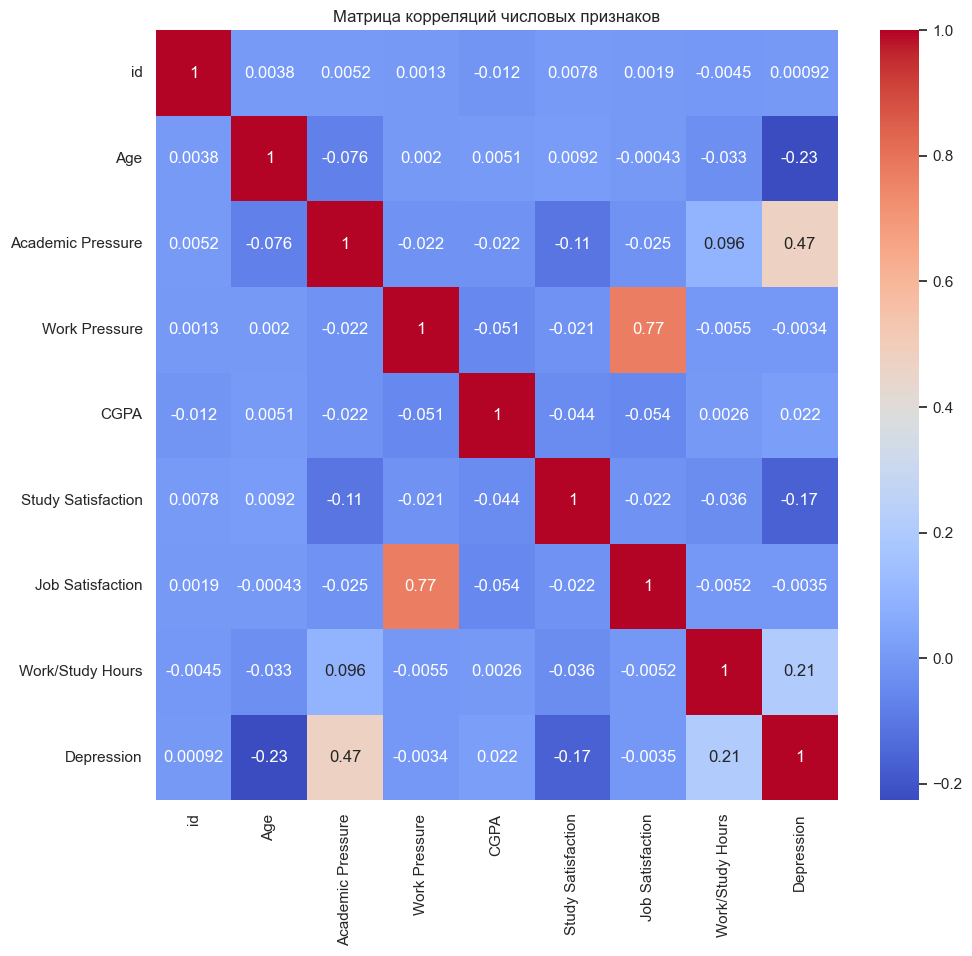

In [36]:
# Матрица корреляций для числовых признаков
numeric_cols = raw_data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = raw_data[numeric_cols].corr()

plt.figure(figsize=(11, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Матрица корреляций числовых признаков')
plt.show()

## Часть 2: Preprocessing & Feature Engineering

### Ключевые особенности индийской системы образования и их иерархия

#### 1. Школьное образование
1. **Class 12** - Higher Secondary Certificate (HSC)

---

#### 2. Бакалавриат (3-4 года)
2. **BHM** - Bachelor of Hotel Management  
3. **BBA** - Bachelor of Business Administration  
4. **BCA** - Bachelor of Computer Applications  
5. **B.Com** - Bachelor of Commerce  
6. **BA** - Bachelor of Arts  
7. **BSc** - Bachelor of Science  
8. **B.Pharm** - Bachelor of Pharmacy (4 года)  
9. **B.Arch** - Bachelor of Architecture (5 лет)  
10. **B.Tech** / **BE** - Bachelor of Technology / Engineering (4 года)  
11. **MBBS** - Bachelor of Medicine and Bachelor of Surgery (5.5 лет)

---

#### 3. Последипломное образование (требует бакалавриата)
12. **LLB** - Bachelor of Laws (3 года после другого бакалавриата)  
13. **B.Ed** - Bachelor of Education (1-2 года после бакалавриата)

---

#### 4. Магистратура (2 года)
14. **MHM** - Master of Hotel Management  
15. **MCA** - Master of Computer Applications  
16. **M.Com** - Master of Commerce  
17. **MA** - Master of Arts  
18. **MSc** - Master of Science  
19. **M.Pharm** - Master of Pharmacy  
20. **M.Tech** / **ME** - Master of Technology / Engineering  
21. **M.Ed** - Master of Education  
22. **MBA** - Master of Business Administration  
23. **LLM** - Master of Laws

---

#### 5. Докторантура/Высшая специализация
24. **MD** - Doctor of Medicine (3 года после MBBS + интернатура)  
25. **PhD** - Doctor of Philosophy

### Особенности индийской географии

|N| Название города | Широта | Долгота | Регион | Геодезическая X | Геодезическая Y |
|:-| :- | :- | :- | :- | :- | :- |
|1|**Visakhapatnam**|17\.6868° N|83\.2185° E|Андхра-Прадеш|1957702\.448|14735409\.934|
|2|**Bangalore**|12\.9716° N|77\.5946° E|Карнатака|1436000\.782|13781593\.817|
|3|**Srinagar**|34\.0837° N|74\.7973° E|Джамму и Кашмир|3772964\.011|13481292\.175|
|4|**Varanasi**|25\.3176° N|82\.9739° E|Уттар-Прадеш|2802700\.841|14698775\.385|
|5|**Jaipur**|26\.9124° N|75\.7873° E|Раджастхан|2978167\.009|13578205\.486|
|6|**Pune**|18\.5204° N|73\.8567° E|Махараштра|2048964\.129|13379272\.728|
|7|**Thane**|19\.2183° N|72\.9781° E|Махараштра|2127067\.800|13287354\.648|
|8|**Chennai**|13\.0827° N|80\.2707° E|Тамилнад|1446973\.891|14420906\.602|
|9|**Nagpur**|21\.1458° N|79\.0882° E|Махараштра|2340415\.038|14301395\.812|
|10|**Nashik**|20\.0059° N|73\.7910° E|Махараштра|2213476\.040|13373479\.350|
|11|**Vadodara**|22\.3072° N|73\.1812° E|Гуджарат|2468946\.777|13312571\.647|
|12|**Kalyan**|19\.2350° N|73\.1299° E|Махараштра|2128738\.570|13303344\.167|
|13|**Rajkot**|22\.3039° N|70\.8022° E|Гуджарат|2468560\.703|12685722\.063|
|14|**Ahmedabad**|23\.0225° N|72\.5714° E|Гуджарат|2549093\.885|13251003\.164|
|15|**Kolkata**|22\.5726° N|88\.3639° E|Западная Бенгалия|2497847\.680|15640276\.422|
|16|**Mumbai**|19\.0760° N|72\.8777° E|Махараштра|2111433\.327|13276600\.180|
|17|**Lucknow**|26\.8467° N|80\.9462° E|Уттар-Прадеш|2970645\.254|14494653\.055|
|18|**Indore**|22\.7196° N|75\.8577° E|Мадхья-Прадеш|2513740\.122|13588116\.669|
|19|**Surat**|21\.1702° N|72\.8311° E|Гуджарат|2343461\.405|13274715\.393|
|20|**Ludhiana**|30\.9010° N|75\.8573° E|Пенджаб|3420313\.040|13581961\.913|
|21|**Bhopal**|23\.2599° N|77\.4126° E|Мадхья-Прадеш|2575374\.070|13746920\.510|
|22|**Meerut**|28\.9845° N|77\.7064° E|Уттар-Прадеш|3210571\.693|13763800\.568|
|23|**Agra**|27\.1767° N|78\.0081° E|Уттар-Прадеш|3010748\.102|14203425\.975|
|24|**Ghaziabad**|28\.6692° N|77\.4538° E|Уттар-Прадеш|3175070\.985|13739892\.901|
|25|**Khaziabad**|28\.6692° N|77\.4538° E|Уттар-Прадеш|3175070\.985|13739892\.901|
|26|**Hyderabad**|17\.3850° N|78\.4867° E|Телангана|1924667\.064|14232850\.965|
|27|**Vasai-Virar**|19\.4259° N|72\.8225° E|Махараштра (городской агломерат)|2150258\.900|13271273\.307|
|28|**Kanpur**|26\.4499° N|80\.3319° E|Уттар-Прадеш|2926852\.516|14433367\.472|
|29|**Patna**|25\.5941° N|85\.1376° E|Бихар|2833180\.851|15312884\.075|
|30|**Faridabad**|28\.4089° N|77\.3178° E|Харьяна|3145943\.637|13727151\.081|
|31|**Delhi**|28\.7041° N|77\.1025° E|Национальная столичная территория Дели|3178284\.724|13705471\.225|
|32|**Mira**|19\.2870° N|72\.8686° E|Махараштра (пригород Мумбаи)|2134814\.205|13275927\.700|
|33|**Less Delhi**|28\.7041° N|77\.1025° E|Национальная столичная территория Дели|3178284\.724|13705471\.225|
|34|**City**|28\.7041° N|77\.1025° E|Национальная столичная территория Дели|3178284\.724|13705471\.225|


Негеографические названия (имена людей, степени, слова "City", "Less Delhi", "Less than 5 Kalyan", числовые значения) и несуществующие топонимы ('Saanvi', 'Nalyan', 'Kibara') будем считать за Дели как наиболее вероятные.

###  Преобразуем уровень образования

In [38]:
class EducationTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, column_name):
        self.edu_cat = {
            0: ("Others"),
            10: ("Class 12"),
            20: ("BHM", "BBA", "BCA", "B.Com", "BA", "BSc", "B.Pharm", "B.Arch", "B.Tech", "BE", "MBBS"),
            30: ("LLB", "B.Ed"),
            40: ("MHM", "MC", "MCA", "M.Com", "MA", "MSc", "M.Pharm", "M.Tech", "ME", "M.Ed", "MBA", "LLM"),
            50: ("MD", "PhD"),
        }

        self.column_name = column_name

    def get_new_value(self, x):
        rez = 0
        for k, v in self.edu_cat.items():
            if x in v:
                rez = k+v.index(x)*0.5
                break
        return rez

    def fit(self,y=None,x=None):
        return self  # The fit method typically does nothing for transformers

    def transform(self, X):
        x_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        # Check if the specified column is numerical
        if self.column_name in x_transformed.columns:
            x_transformed[self.column_name]=x_transformed[self.column_name].apply(self.get_new_value)
        return x_transformed


edu_transformer = EducationTransformer(column_name='Degree',)
df_transformed = edu_transformer.fit_transform(df)
df_transformed.head()

,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,23.0,Yes,3.0,1.0,No,1
1,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,22.5,No,3.0,2.0,Yes,0
2,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,22.0,No,9.0,1.0,Yes,0
3,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,21.0,Yes,4.0,5.0,Yes,1
4,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,43.5,Yes,1.0,1.0,No,0


###  Преобразуем город в координаты

<Axes: xlabel='Citydec_x', ylabel='Citydec_y'>

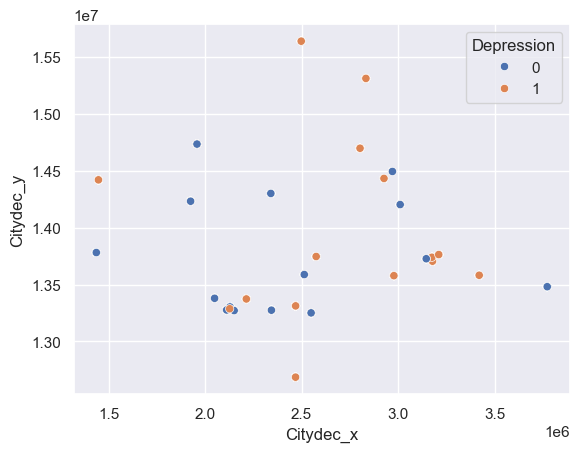

In [39]:
class coordsTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, column_name):
        self.cyty_coord = {
            "Visakhapatnam": [1957702.448, 14735409.934],
            "Bangalore": [1436000.782, 13781593.817],
            "Srinagar": [3772964.011, 13481292.175],
            "Varanasi": [2802700.841, 14698775.385],
            "Jaipur": [2978167.009, 13578205.486],
            "Pune": [2048964.129, 13379272.728],
            "Thane": [2127067.800, 13287354.648],
            "Chennai": [1446973.891, 14420906.602],
            "Nagpur": [2340415.038, 14301395.812],
            "Nashik": [2213476.040, 13373479.350],
            "Vadodara": [2468946.777, 13312571.647],
            "Kalyan": [2128738.570, 13303344.167],
            "Rajkot": [2468560.703, 12685722.063],
            "Ahmedabad": [2549093.885, 13251003.164],
            "Kolkata": [2497847.680, 15640276.422],
            "Mumbai": [2111433.327, 13276600.180],
            "Lucknow": [2970645.254, 14494653.055],
            "Indore": [2513740.122, 13588116.669],
            "Surat": [2343461.405, 13274715.393],
            "Ludhiana": [3420313.040, 13581961.913],
            "Bhopal": [2575374.070, 13746920.510],
            "Meerut": [3210571.693, 13763800.568],
            "Agra": [3010748.102, 14203425.975],
            "Ghaziabad": [3175070.985, 13739892.901],
            "Hyderabad": [1924667.064, 14232850.965],
            "Vasai-Virar": [2150258.900, 13271273.307],
            "Kanpur": [2926852.516, 14433367.472],
            "Patna": [2833180.851, 15312884.075],
            "Faridabad": [3145943.637, 13727151.081],
            "Delhi": [3178284.724, 13705471.225],
            "Mira": [2134814.205, 13275927.700],
        }

        self.column_name = column_name

    def get_x_value(self, x):
        rez = 3178284.724
        if x in self.cyty_coord:
            rez = self.cyty_coord[x][0]
        return rez
    
    def get_y_value(self, x):
        rez = 13705471.225
        if x in self.cyty_coord:
            rez = self.cyty_coord[x][1]
        return rez

    def fit(self, y=None, x=None):
        return self  # The fit method typically does nothing for transformers

    def transform(self, X):
        x_transformed = X.copy()  # Copy the input DataFrame to avoid modifying the original
        # Check if the specified column is numerical
        if self.column_name in x_transformed.columns:
            x_transformed[self.column_name+"dec_x"] = x_transformed[self.column_name].apply(self.get_x_value)
            x_transformed[self.column_name+"dec_y"] = x_transformed[self.column_name].apply(self.get_y_value)
        return x_transformed.drop([self.column_name], axis=1)
    
coord_stransformer = coordsTransformer(column_name='City')
df_transformed = coord_stransformer.fit_transform(df_transformed)
df_transformed.head()

sns.scatterplot(data=df_transformed,x='Citydec_x',y='Citydec_y',hue='Depression')

In [40]:
# Поиск всех категориальных признаков
categorical_cols = df_transformed.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(col.title())
    print(df_transformed[col].unique())
    print(len(raw_data[col].unique()))
    print("_______________________________")

Gender
['Male' 'Female']
2
_______________________________
Profession
['Student' "'Civil Engineer'" 'Architect' "'UX/UI Designer'"
 "'Digital Marketer'" "'Content Writer'" "'Educational Consultant'"
 'Teacher' 'Manager' 'Chef' 'Doctor' 'Lawyer' 'Entrepreneur' 'Pharmacist']
14
_______________________________
Sleep Duration
["'5-6 hours'" "'Less than 5 hours'" "'7-8 hours'" "'More than 8 hours'"
 'Others']
5
_______________________________
Dietary Habits
['Healthy' 'Moderate' 'Unhealthy' 'Others']
4
_______________________________
Have You Ever Had Suicidal Thoughts ?
['Yes' 'No']
2
_______________________________
Financial Stress
['1.0' '2.0' '5.0' '3.0' '4.0' '?']
6
_______________________________
Family History Of Mental Illness
['No' 'Yes']
2
_______________________________


## Часть 3: Моделирование

In [41]:
X_data = raw_data.drop(['Depression'], axis=1)
y_data = raw_data['Depression']

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.3, random_state=12345, stratify=y_data
)

### Pipelines

In [42]:
# Зададим транформер колонок
categorial_tr = ColumnTransformer(
    [
       ('ordinal', OrdinalEncoder(), ['Profession','Dietary Habits','Financial Stress','Sleep Duration']),
       ('education', EducationTransformer(column_name='Degree'),['Degree']),
       ('coords', coordsTransformer(column_name='City'),['City'])
    ]
)

preprocessor_pipeline = Pipeline([
    ('cat_transf_1', categorial_tr),
    ('cat_transf_2', OneHotEncoder()),
    ('numeric_trans', StandardScaler()),

])

### Логистическая регрессия

In [43]:
clr_lassifier_pipline = Pipeline([
    ("preprocessor",preprocessor_pipeline),
    ("classifier", LogisticRegression()),
])
clr_lassifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transf_1',
                                  ColumnTransformer(transformers=[('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['Profession',
                                                                    'Dietary '
                                                                    'Habits',
                                                                    'Financial '
                                                                    'Stress',
                                                                    'Sleep '
                                                                    'Duration']),
                                                                  ('education',
                                                                   EducationTransformer(column_name='Degree'),
                                                                   ['Degree']),
                                                                  ('coords',
                                                                   coordsTransformer(column_name='City'),
                                                                   ['City'])])),
                                 ('cat_transf_2', OneHotEncoder()),
                                 ('numeric_trans', StandardScaler())])),
                ('classifier', LogisticRegression())])

In [70]:
clr_lassifier_pipline.fit(X_train,y_train)
preds = clr_lassifier_pipline.predict(X_test)

print(classification_report(y_test, preds))


              precision    recall  f1-score   support

           0       0.58      0.34      0.43      3470
           1       0.64      0.82      0.72      4901

    accuracy                           0.62      8371
   macro avg       0.61      0.58      0.58      8371
weighted avg       0.61      0.62      0.60      8371



#### Дерево решений

In [45]:
d_tree_class=DecisionTreeClassifier()

dtree_classifier_pipline = Pipeline([
    ("preprocessor",preprocessor_pipeline),
    ("classifier", d_tree_class),
])
dtree_classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transf_1',
                                  ColumnTransformer(transformers=[('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['Profession',
                                                                    'Dietary '
                                                                    'Habits',
                                                                    'Financial '
                                                                    'Stress',
                                                                    'Sleep '
                                                                    'Duration']),
                                                                  ('education',
                                                                   EducationTransformer(column_name='Degree'),
                                                                   ['Degree']),
                                                                  ('coords',
                                                                   coordsTransformer(column_name='City'),
                                                                   ['City'])])),
                                 ('cat_transf_2', OneHotEncoder(cols=[])),
                                 ('numeric_trans', StandardScaler())])),
                ('classifier', DecisionTreeClassifier())])

In [46]:
param_grid = {
    "classifier__max_depth": [1, 3, 5, 7, 10],
    "classifier__min_samples_split": [2, 5, 10, 20],
    "classifier__min_samples_leaf": [1, 5, 10, 50],
}

search = GridSearchCV(dtree_classifier_pipline, param_grid, n_jobs=1, cv=3, scoring="accuracy")


search.fit(X_train, y_train)
preds = search.predict(X_test)
print(search.best_params_)
print(classification_report(y_test, preds))

{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 50, 'classifier__min_samples_split': 2}
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      3470
           1       0.73      0.76      0.75      4901

    accuracy                           0.69      8371
   macro avg       0.68      0.68      0.68      8371
weighted avg       0.69      0.69      0.69      8371



#### Лес деревьев

In [47]:
rf_classifier=RandomForestClassifier()
forest_classifier_pipline = Pipeline([
    ("preprocessor",preprocessor_pipeline),
    ("classifier", rf_classifier),
])
forest_classifier_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transf_1',
                                  ColumnTransformer(transformers=[('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['Profession',
                                                                    'Dietary '
                                                                    'Habits',
                                                                    'Financial '
                                                                    'Stress',
                                                                    'Sleep '
                                                                    'Duration']),
                                                                  ('education',
                                                                   EducationTransformer(column_name='Degree'),
                                                                   ['Degree']),
                                                                  ('coords',
                                                                   coordsTransformer(column_name='City'),
                                                                   ['City'])])),
                                 ('cat_transf_2', OneHotEncoder(cols=[])),
                                 ('numeric_trans', StandardScaler())])),
                ('classifier', RandomForestClassifier())])

In [48]:
param_grid = {
    "classifier__n_estimators": [3, 5, 7],
    "classifier__max_depth": [1, 3, 5, 7],
    "classifier__min_samples_split": [1,2, 3, 5],
    "classifier__min_samples_leaf": [1, 2, 3, 5],
}

search = GridSearchCV(forest_classifier_pipline, param_grid, n_jobs=1, cv=3, scoring="accuracy")

search.fit(X_train, y_train)
preds = search.predict(X_test)
print(search.best_params_)
print(classification_report(y_test, preds))

{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 5}
              precision    recall  f1-score   support

           0       0.68      0.42      0.52      3470
           1       0.68      0.86      0.76      4901

    accuracy                           0.68      8371
   macro avg       0.68      0.64      0.64      8371
weighted avg       0.68      0.68      0.66      8371



### Лес деревьев в лоб

In [49]:
forest_raw_classifier_pipline = Pipeline([
    ("encoder",OrdinalEncoder()),
    ("scaler",StandardScaler()),
    ("classifier", rf_classifier),
])
forest_raw_classifier_pipline

Pipeline(steps=[('encoder', OrdinalEncoder()), ('scaler', StandardScaler()),
                ('classifier', RandomForestClassifier())])

In [50]:
param_grid = {
    "classifier__n_estimators": [3, 5, 7],
    "classifier__max_depth": [1, 3, 5, 7],
    "classifier__min_samples_split": [1,2, 3, 5],
    "classifier__min_samples_leaf": [1, 2, 3, 5],
}

search = GridSearchCV(forest_raw_classifier_pipline, param_grid, n_jobs=1, cv=3, scoring="accuracy")

search.fit(X_train, y_train)
preds = search.predict(X_test)
print(search.best_params_)
print(classification_report(y_test, preds))

{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 7}
              precision    recall  f1-score   support

           0       0.82      0.74      0.78      3470
           1       0.83      0.89      0.86      4901

    accuracy                           0.83      8371
   macro avg       0.82      0.81      0.82      8371
weighted avg       0.83      0.83      0.82      8371



#### CatBoost

In [51]:
cat_boost_pipline = Pipeline([
    ("preprocessor",preprocessor_pipeline),
    ("classifier", CatBoostClassifier(iterations=100,random_seed=63,learning_rate=0.15,custom_loss=['AUC', 'Accuracy'])),
])
cat_boost_pipline

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('cat_transf_1',
                                  ColumnTransformer(transformers=[('ordinal',
                                                                   OrdinalEncoder(),
                                                                   ['Profession',
                                                                    'Dietary '
                                                                    'Habits',
                                                                    'Financial '
                                                                    'Stress',
                                                                    'Sleep '
                                                                    'Duration']),
                                                                  ('education',
                                                                   EducationTransformer(column_name='Degree'),
                                                                   ['Degree']),
                                                                  ('coords',
                                                                   coordsTransformer(column_name='City'),
                                                                   ['City'])])),
                                 ('cat_transf_2', OneHotEncoder(cols=[])),
                                 ('numeric_trans', StandardScaler())])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002ADB5789E80>)])

In [52]:
cat_boost_pipline.fit(X_train, y_train)
preds = cat_boost_pipline.predict(X_test)
print(classification_report(y_test, preds))

0:	learn: 0.6670899	total: 142ms	remaining: 14.1s
1:	learn: 0.6489097	total: 144ms	remaining: 7.07s
2:	learn: 0.6354308	total: 146ms	remaining: 4.72s
3:	learn: 0.6250907	total: 148ms	remaining: 3.55s
4:	learn: 0.6183958	total: 150ms	remaining: 2.85s
5:	learn: 0.6109793	total: 152ms	remaining: 2.39s
6:	learn: 0.6052492	total: 155ms	remaining: 2.06s
7:	learn: 0.6006587	total: 157ms	remaining: 1.81s
8:	learn: 0.5971800	total: 159ms	remaining: 1.61s
9:	learn: 0.5942609	total: 161ms	remaining: 1.45s
10:	learn: 0.5919348	total: 163ms	remaining: 1.32s
11:	learn: 0.5902398	total: 166ms	remaining: 1.22s
12:	learn: 0.5887270	total: 169ms	remaining: 1.13s
13:	learn: 0.5877176	total: 171ms	remaining: 1.05s
14:	learn: 0.5869352	total: 173ms	remaining: 980ms
15:	learn: 0.5858795	total: 175ms	remaining: 919ms
16:	learn: 0.5848368	total: 177ms	remaining: 864ms
17:	learn: 0.5842962	total: 179ms	remaining: 816ms
18:	learn: 0.5832925	total: 183ms	remaining: 779ms
19:	learn: 0.5826001	total: 185ms	remaini

#### CatBoost в лоб

In [62]:
cat_bt_clf = CatBoostClassifier(
    cat_features=raw_data.select_dtypes(include=["object"]).columns.to_list(),
    iterations=100,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=["AUC", "Accuracy"],
)

cat_boost_raw_pipline = Pipeline(
    [
        ("classifier", cat_bt_clf),

    ]
)

cat_boost_raw_pipline

Pipeline(steps=[('classifier',
                 <catboost.core.CatBoostClassifier object at 0x000002ADB571FAC0>)])

In [63]:
cat_boost_raw_pipline.fit(X_train, y_train)
preds = cat_boost_raw_pipline.predict(X_test)
print(classification_report(y_test, preds))

0:	learn: 0.6292368	total: 26ms	remaining: 2.58s
1:	learn: 0.5809612	total: 58.2ms	remaining: 2.85s
2:	learn: 0.5395895	total: 80.8ms	remaining: 2.61s
3:	learn: 0.5062958	total: 115ms	remaining: 2.76s
4:	learn: 0.4812615	total: 141ms	remaining: 2.67s
5:	learn: 0.4601038	total: 166ms	remaining: 2.6s
6:	learn: 0.4430470	total: 193ms	remaining: 2.56s
7:	learn: 0.4286564	total: 223ms	remaining: 2.56s
8:	learn: 0.4177148	total: 249ms	remaining: 2.51s
9:	learn: 0.4077348	total: 275ms	remaining: 2.48s
10:	learn: 0.3990100	total: 306ms	remaining: 2.48s
11:	learn: 0.3921251	total: 336ms	remaining: 2.46s
12:	learn: 0.3861095	total: 362ms	remaining: 2.42s
13:	learn: 0.3810239	total: 394ms	remaining: 2.42s
14:	learn: 0.3763806	total: 419ms	remaining: 2.37s
15:	learn: 0.3723169	total: 444ms	remaining: 2.33s
16:	learn: 0.3691826	total: 470ms	remaining: 2.29s
17:	learn: 0.3662240	total: 503ms	remaining: 2.29s
18:	learn: 0.3635248	total: 535ms	remaining: 2.28s
19:	learn: 0.3612632	total: 560ms	remaini

0:	learn: 0.6248884	total: 30.9ms	remaining: 3.06s
1:	learn: 0.5744585	total: 60.8ms	remaining: 2.98s
2:	learn: 0.5344140	total: 89.1ms	remaining: 2.88s
3:	learn: 0.5033524	total: 118ms	remaining: 2.83s
4:	learn: 0.4784439	total: 153ms	remaining: 2.9s
5:	learn: 0.4588307	total: 184ms	remaining: 2.88s
6:	learn: 0.4421717	total: 210ms	remaining: 2.79s
7:	learn: 0.4284809	total: 235ms	remaining: 2.7s
8:	learn: 0.4161965	total: 262ms	remaining: 2.65s
9:	learn: 0.4065234	total: 299ms	remaining: 2.69s
10:	learn: 0.3990101	total: 330ms	remaining: 2.67s
11:	learn: 0.3926312	total: 355ms	remaining: 2.6s
12:	learn: 0.3869802	total: 380ms	remaining: 2.54s
13:	learn: 0.3818246	total: 406ms	remaining: 2.49s
14:	learn: 0.3774824	total: 441ms	remaining: 2.5s
15:	learn: 0.3738286	total: 470ms	remaining: 2.46s
16:	learn: 0.3711403	total: 496ms	remaining: 2.42s
17:	learn: 0.3687108	total: 521ms	remaining: 2.37s
18:	learn: 0.3663704	total: 545ms	remaining: 2.32s
19:	learn: 0.3638178	total: 570ms	remainin

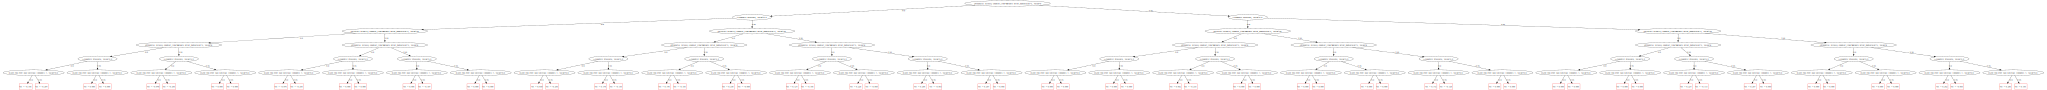

In [55]:
X = raw_data.drop(["Depression"], axis=1)
y = raw_data["Depression"]

is_cat = X.dtypes != float
for feature, feat_is_cat in is_cat.to_dict().items():
    if feat_is_cat:
        X[feature].fillna("NAN", inplace=True)

cat_features_index = np.where(is_cat)[0]
pool = Pool(X, y, cat_features=cat_features_index, feature_names=list(X.columns))

model = CatBoostClassifier(
                cat_features=cat_features_index,
                iterations=100,
                random_seed=63,
                learning_rate=0.15,
                custom_loss=["AUC", "Accuracy"])
model.fit(pool)
model.plot_tree(tree_idx=0, pool=pool)


#### Ансамбль моделей


In [64]:
voting_classifier = VotingClassifier(
    estimators=[("cat_boost", LogisticRegression()), 
                ("random_forest", rf_classifier)]
)
voting_classifier

VotingClassifier(estimators=[('cat_boost', LogisticRegression()),
                             ('random_forest', RandomForestClassifier())])

In [65]:
voting_pipline = Pipeline(
    [
        ("encoder",OrdinalEncoder()),
        ("scaler",StandardScaler()),
        ("classifier", voting_classifier)
    ]
)
voting_pipline

Pipeline(steps=[('encoder', OrdinalEncoder()), ('scaler', StandardScaler()),
                ('classifier',
                 VotingClassifier(estimators=[('cat_boost',
                                               LogisticRegression()),
                                              ('random_forest',
                                               RandomForestClassifier())]))])

In [66]:
voting_pipline.fit(X_train, y_train)
preds = voting_pipline.predict(X_test)
print(search.best_params_)
print(classification_report(y_test, preds))

{'classifier__max_depth': 7, 'classifier__min_samples_leaf': 3, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 7}
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      3470
           1       0.86      0.84      0.85      4901

    accuracy                           0.83      8371
   macro avg       0.82      0.83      0.82      8371
weighted avg       0.83      0.83      0.83      8371

